In [1]:
import sys
import pandas as pd
import datetime
import os.path
from os import path
import requests
import numpy as np
import time
import pytz
# from sklearn.impute import KNNImputer
import json
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
import calendar
import os
from dateutil.relativedelta import relativedelta
from dateutil.tz import gettz
import timeit
# from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
address = "https://m3.meazon.com/"

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def gof(x,y,step):
    lgof = np.absolute(np.sum((y-x)**2/x))
    if lgof> chi[step-2]:
        lgof=1
    else:
        lgof= 0
    return lgof

def actpwr(x,y):
    diff = np.absolute(np.mean(y)-np.mean(x))
    
    return diff

# chi = [6.63,9.21,11.3,13.3,15.1,16.8,18.5,20.1,21.7,23.2,24.7,26.2,27.7,29.1,30.6,32,33.4,34.8,36.2,37.6,38.9,40.3,41.6,43,44.3,45.6,47,48.3,49.6,61.098, 62.487, 63.87, 65.247, 66.619, 67.985, 69.346, 70.703, 72.055, 73.402, 74.745, 76.084, 77.419, 78.75, 80.077, 81.4, 82.72, 84.037, 85.351, 86.661, 87.968, 89.272, 90.573, 91.872, 93.168, 94.461, 95.751, 97.039, 98.324, 99.607]
chi = [6.635,9.21,11.345,13.277,15.086,16.812,18.475,20.09,21.666,23.209,24.725,26.217,27.688,29.141,30.578,32,33.409,34.805,36.191,37.566,38.932,40.289,41.638,42.98,44.314,45.642,46.963,48.278,49.588,50.892,52.191,53.486,54.776,56.061,57.342,58.619,59.893,61.162,62.428,63.691,64.95,66.206,67.459,68.71,69.957,71.201,72.443,73.683,74.919,76.154,77.386,78.616,79.843,81.069,82.292,83.513,84.733,85.95,87.166,88.379,89.591,90.802,92.01,93.217,94.422,95.626,96.828,98.028,99.228,100.425,101.621,102.816,104.01,105.202,106.393,107.583,108.771,109.958,111.144,112.329,113.512,114.695,115.876,117.057,118.236,119.414,120.591,121.767,122.942,124.116,125.289,126.462,127.633,128.803,129.973,131.141,132.309,133.476,134.642,135.807,136.971,138.134,139.297,140.459,141.62,142.78,143.94,145.099,146.257,147.414,148.571,149.727,150.882,152.037,153.191,154.344,155.496,156.648,157.8,158.95,160.1,161.25,162.398,163.546,164.694,165.841,166.987,168.133,169.278,170.423,171.567,172.711,173.854,174.996,176.138,177.28,178.421,179.561,180.701,181.84,182.979,184.118,185.256,186.393,187.53,188.666,189.802,190.938,192.073,193.208,194.342,195.476,196.609,197.742,198.874,200.006,201.138,202.269,203.4,204.53,205.66,206.79,207.919,209.047,210.176,211.304,212.431,213.558,214.685,215.812,216.938,218.063,219.189,220.314,221.438,222.563,223.687,224.81,225.933,227.056,228.179,229.301,230.423,231.544,232.665,233.786,234.907,236.027,237.147,238.266,239.386,240.505,241.623,242.742,243.86,244.977,246.095,247.212,248.329,249.445
]
len(chi)

200

In [3]:
# read data from csv
df = pd.read_csv('../disagData/emily/tv_hairdryer_power.csv')
df['Timestamp'] = pd.to_datetime(df['ts'], unit='ms')
df = df.sort_values(by="Timestamp")

# df['Timestamp'] = df['Timestamp'].astype('datetime64[s]')
df = df.set_index('Timestamp', drop=True)
for col in df.columns:
    df[col] = df[col].astype('float64')
    
# df includes active and apparent power columns, along with timestamps

df['totalpwr'] =df['pwrA']+df['rpwrA']* 1j 
df['active'] = df['pwrA']
df['reactive'] = df['rpwrA']
# df['cl'] = 0
df.loc[df['active']>17.5,'cl']=1
dfcomp = df[['totalpwr','active','reactive']]
df =df[['active']]

dfcomp = dfcomp.resample('500L').mean()
df = df.resample('500L').mean()

df = df.dropna()
dfcomp = dfcomp.dropna()
# dfcomp['totalpwr'] = sp.signal.medfilt(dfcomp['totalpwr'])
# df['totalpwr'] = sp.signal.medfilt(df['totalpwr'])
df.head()


,active
Timestamp,
2020-05-06 08:04:32.500,21.065921
2020-05-06 08:04:33.000,12.115480
2020-05-06 08:04:33.500,17.173276
2020-05-06 08:04:34.000,22.163052
2020-05-06 08:04:34.500,22.399508


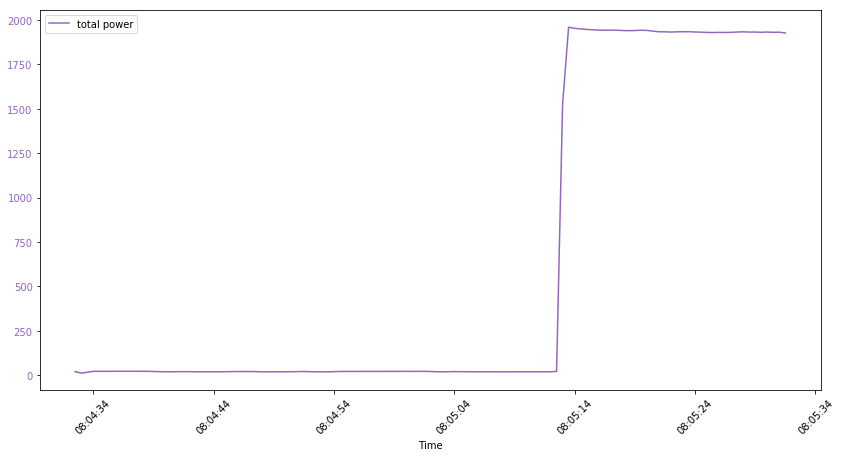

In [87]:
# plot raw data
i=0
fig, ax1 = plt.subplots(figsize=(14, 7.0))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

color = 'tab:purple'
ax1.set_xlabel('Time')
# ax1.set_ylabel('Apparent power [VA]', color=color)
ax1.plot(df.index, df['active'], color=color)
# ax1.plot(dfcomp.index, dfcomp['cl'])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['total power'], loc=2)


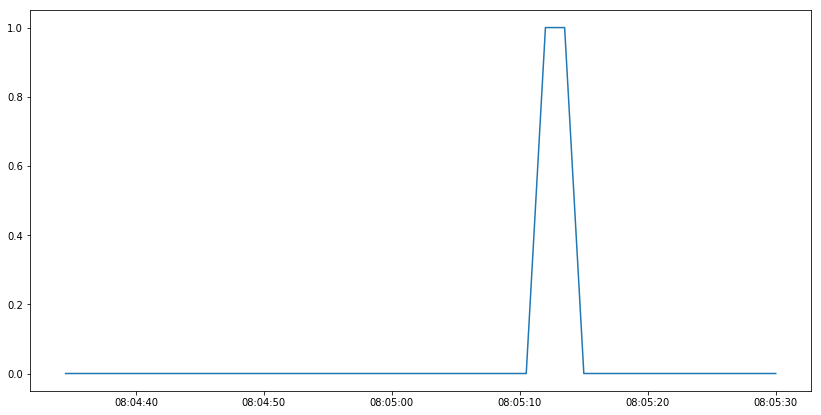

In [102]:
# Define window size as step, apply gof function over rows to detect events

step = 3

supervised = series_to_supervised(df, step, step)
supervised = supervised.iloc[1::step, :]
# supervised['lgof']=0

# for i in range(0,supervised.shape[0]):
#     supervised['lgof'].iloc[i] = gof(supervised[supervised.columns[:step]].iloc[i].values,supervised[supervised.columns[step:-1]].iloc[i].values,step)
gof_row = lambda row: gof(row[:step].values, row[step:].values,step)
actrow = lambda row: actpwr(row[:step].values, row[step:-1].values)
supervised['lgof'] = supervised.apply(gof_row,axis=1) #lambda row : gof(row[['var1(t-3)','var1(t-2)','var1(t-1)']].values,row[['var1(t)','var1(t+1)','var1(t+2)']].values ), axis = 1) 
supervised['actpwr'] = supervised.apply(actrow,axis=1)
supervised.loc[(supervised['actpwr']<20) & (supervised['lgof']>0),'lgof']=0

fig = plt.figure(figsize=(14, 7.0))
plt.plot(supervised.index,supervised.lgof)


In [101]:
supervised

,var1(t-2),var1(t-1),var1(t),var1(t+1),lgof,actpwr
Timestamp,,,,,,
2020-05-06 08:04:34,12.115480,17.173276,22.163052,22.399508,0,7.636902
2020-05-06 08:04:35,22.163052,22.399508,22.281280,22.367800,0,0.043260
2020-05-06 08:04:36,22.281280,22.367800,22.935788,22.665008,0,0.475858
2020-05-06 08:04:37,22.935788,22.665008,22.563288,22.590388,0,0.223560
2020-05-06 08:04:38,22.563288,22.590388,22.438472,22.433192,0,0.141006
2020-05-06 08:04:39,22.438472,22.433192,21.456360,20.424736,0,1.495284
2020-05-06 08:04:40,21.456360,20.424736,19.987504,20.009192,0,0.942200
2020-05-06 08:04:41,19.987504,20.009192,20.179032,20.647300,0,0.414818
2020-05-06 08:04:42,20.179032,20.647300,20.319712,19.700856,0,0.402882


In [19]:
# # Define window size as step, apply gof function over rows to detect events

# step = 30
# supervised = series_to_supervised(dfcomp[['reactive']], step, step)
# supervised = supervised.iloc[1::step, :]
# # supervised['lgof']=0

# # for i in range(0,supervised.shape[0]):
# #     supervised['lgof'].iloc[i] = gof(supervised[supervised.columns[:step]].iloc[i].values,supervised[supervised.columns[step:-1]].iloc[i].values,step)
# gof_row = lambda row: gof(row[:step].values, row[step:].values,step)
# supervised['lgof'] = supervised.apply(gof_row,axis=1) #lambda row : gof(row[['var1(t-3)','var1(t-2)','var1(t-1)']].values,row[['var1(t)','var1(t+1)','var1(t+2)']].values ), axis = 1) 

# fig = plt.figure(figsize=(14, 7.0))
# plt.plot(supervised.index,supervised.lgof)

In [20]:
# supervised['lgof'] = supervised['lgof'] +supervised1['lgof'].values
# supervised.loc[supervised['lgof']==2,['lgof']]=1
# supervised['lgof'].value_counts()

In [100]:
# Average df's rows every [step] rows and concatenate active and apparent power to supervised

dfn = dfcomp.iloc[step+1:].copy()
dfn['ts'] = dfn.index
dfn.reset_index(inplace=True,drop=True)
dfn = dfn.groupby(np.arange(len(dfn))//step).mean()
dfn = dfn.iloc[:-1]
supervised['totalpwr'] = dfn['totalpwr'].values
supervised['active'] = dfn['active'].values
supervised['reactive'] = dfn['reactive'].values

dfn = supervised.copy()
dfn = dfn[['totalpwr','active','reactive','lgof']]
dfn.head()

ValueError: Length of values does not match length of index

In [34]:
# supper = np.ma.masked_where(dfn['lgof']==1, dfn['totalpwr'])
# slower = np.ma.masked_where(dfn['lgof'] ==0, dfn['totalpwr'])
# fig, ax = plt.subplots(figsize=(14, 7.0))
# plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
# ax.plot(dfn.index, supper,'-',dfn.index,slower,'-*')
# ax.legend(['No event','Event'])

In [68]:

# import matplotlib.colors as colors

# fig, ax1 = plt.subplots(figsize=(14, 7.0))
# plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
# color = 'tab:blue'
# ax1.plot(dfn.index, dfn['totalpwr'], '-')
# ax1.tick_params(axis='y', labelcolor=color)
# ax1.set_ylabel('Apparent power [VoltAmperes]', color=color)
# # Add below threshold markers
# below_threshold = dfn['lgof']>0
# ax1.scatter(dfn.index[below_threshold], dfn['totalpwr'][below_threshold], color='red') 
# ax1.legend(['Steady state','Event'],loc=2)


# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:orange'


# ax2.set_ylabel('Active power [Watts]', color=color)  # we already handled the x-label with ax1
# ax2.plot(dfn.index, dfn['active'], '-',color=color)
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.legend(['Active power'], loc=1)
# plt.title('Event detection')

In [69]:
dfpost = dfn[dfn['lgof']>0].copy()
dfpost.drop('lgof', axis=1, inplace=True)
# dfpost['prev']=dfpost['reactive'].shift()
# dfpost['prev'].iloc[0]=0
dfpost.head()

,totalpwr,active,reactive
Timestamp,,,
2020-05-06 08:05:13,1921.100984+8.430773j,1921.100984,8.430773


In [57]:
n_clusters = 2
km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=50)

print("Clustering sparse data with %s" % km)

dfpost['cluster'] = km.fit_predict(dfpost[['active','reactive']].values)
dfpost['cluster'] = dfpost['cluster'].astype(int)

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=50, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


ValueError: n_samples=1 should be >= n_clusters=2

In [38]:
clustered = pd.concat([dfn,dfpost['cluster']],axis = 1)
# clustered.loc[clustered['cluster'].isna()==True,'cluster']=n_clusters+1
# clustered['cluster'] = clustered['cluster'].astype(int)

# clustered['bool'] = clustered['cluster'].ne(clustered['cluster'].shift())
# clustered.loc[clustered['bool']==False,['cluster']]=np.nan
# clustered.loc[clustered['cluster']==4,['cluster']]=np.nan


In [39]:
tmp = clustered.copy()
tmp = tmp[['cluster']]
tmp.dropna(inplace=True)
tmp['bool'] = tmp['cluster'].ne(tmp['cluster'].shift())
tmp.loc[tmp['bool']==False,['cluster']]=np.nan
tmp.drop('bool',axis=1, inplace=True)
tmp.dropna(inplace=True)
tmp['ts'] = tmp.index
tmp['duration']= (tmp['ts'].shift(-1)-tmp['ts']).dt.total_seconds()
tmp['duration'].iloc[-1]=0
# tmp.loc[tmp['cluster']==4,['cluster']]=np.nan
clustered.drop(['cluster'],axis=1, inplace=True)
clustered = pd.concat([clustered,tmp[['cluster','duration']]],axis = 1)
del tmp
clustered['cluster'].value_counts()

C:\Users\Emily\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


1.0    1
0.0    1
Name: cluster, dtype: int64

C:\Users\Emily\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Emily\Anaconda3\lib\site-packages\numpy\core\numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\Emily\Anaconda3\lib\site-packages\matplotlib\text.py:1775: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(y))
C:\Users\Emily\Anaconda3\lib\site-packages\matplotlib\text.py:893: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
C:\Users\Emily\Anaconda3\lib\site-packages\matplotlib\text.py:761: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(textobj.convert_yunits(textobj._y))


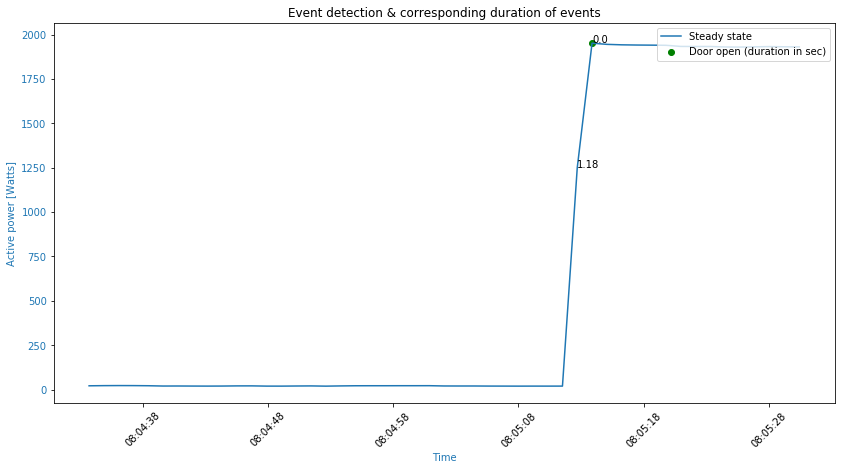

In [40]:
fig, ax1 = plt.subplots(figsize=(14, 7.0))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
color = 'tab:blue'
ax1.plot(clustered.index, clustered['totalpwr'], '-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Active power [Watts]', color=color)
ax1.set_xlabel('Time', color=color)
ax1.set_title('Event detection & corresponding duration of events')

# Add below threshold markers
cl0 = clustered['cluster']==0
cl1 = clustered['cluster']==1.0
# cl2 = clustered['cluster']==2.0
# cl3 = clustered['cluster']==3.0
# cl4 = clustered['cluster']==4.0

# ax1.scatter(clustered.index[cl0], clustered['totalpwr'][cl0], color='red') 
ax1.scatter(clustered.index[cl1], clustered['totalpwr'][cl1], color='green') 
# ax1.scatter(clustered.index[cl2], clustered['totalpwr'][cl2], color='purple') 
# ax1.scatter(clustered.index[cl3], clustered['totalpwr'][cl3], color='cyan') 
# ax1.scatter(clustered.index[cl4], clustered['totalpwr'][cl4], color='orange') 


ax1.legend(['Steady state','Door open (duration in sec)'],loc=1)#,'Event type 2','Event type 3','Event type 4'],loc=2)
dur = clustered.loc[clustered['cluster']==1.0,'duration'].values
for i, txt in enumerate(dur):
    ax1.annotate(txt, (clustered.index[cl1][i], clustered['totalpwr'][cl1][i]))
    
dur = clustered.loc[clustered['cluster']==0.0,'duration'].values
for i, txt in enumerate(dur):
    ax1.annotate(txt, (clustered.index[cl0][i], clustered['totalpwr'][cl0][i]))


# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:orange'
# ax2.set_ylabel('Reactive power [VAR]', color=color)  # we already handled the x-label with ax1
# ax2.plot(dfn.index, dfn['reactive'], '-',color=color)
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.legend(['Reactive power'], loc=1)

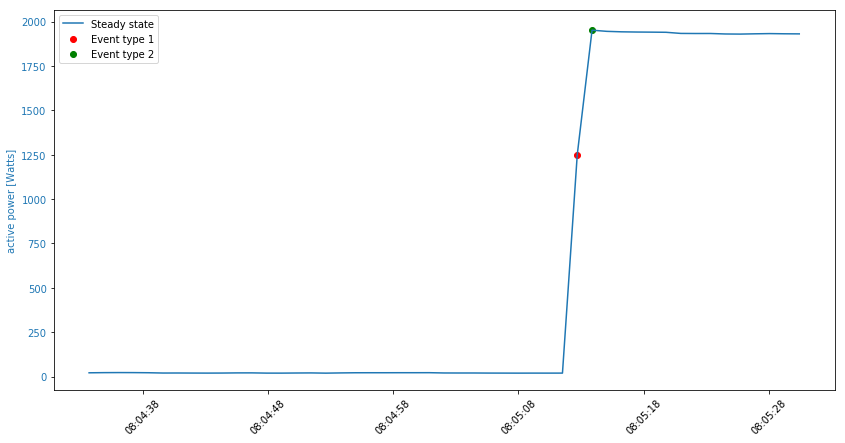

In [41]:
fig, ax1 = plt.subplots(figsize=(14, 7.0))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
color = 'tab:blue'
ax1.plot(clustered.index, clustered['active'], '-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('active power [Watts]', color=color)

# Add below threshold markers
cl0 = clustered['cluster']==0
cl1 = clustered['cluster']==1.0
# cl2 = clustered['cluster']==2.0


ax1.scatter(clustered.index[cl0], clustered['active'][cl0], color='red') 
ax1.scatter(clustered.index[cl1], clustered['active'][cl1], color='green') 
# ax1.scatter(clustered.index[cl2], clustered['reactive'][cl2], color='purple') 

ax1.legend(['Steady state','Event type 1','Event type 2'],loc=2)




In [ ]:
#############################################################################################